<a href="https://colab.research.google.com/github/surya211099/DetectingPhishingEmail/blob/main/MLP%2BLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6267 - loss: 0.6496 - val_accuracy: 0.7049 - val_loss: 0.5849
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7096 - loss: 0.5797 - val_accuracy: 0.7327 - val_loss: 0.5409
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7409 - loss: 0.5303 - val_accuracy: 0.8145 - val_loss: 0.4390
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7983 - loss: 0.4609 - val_accuracy: 0.8243 - val_loss: 0.3984
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8177 - loss: 0.4232 - val_accuracy: 0.8322 - val_loss: 0.3884
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8222 - loss: 0.4135 - val_accuracy: 0.8366 - val_loss: 0.3796
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8246 - loss: 0.4050 - val_accuracy: 0.8396 - val_loss: 0.3825
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8287 - loss: 0.3986 - val_accuracy: 0.

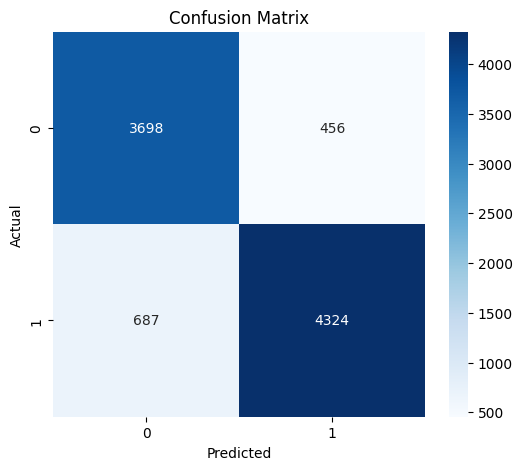

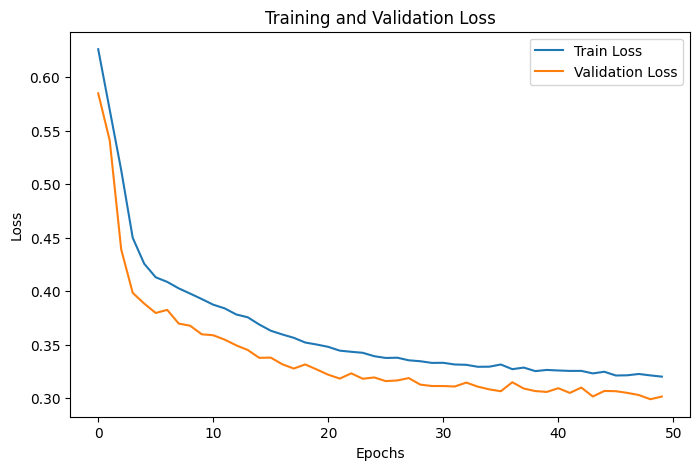

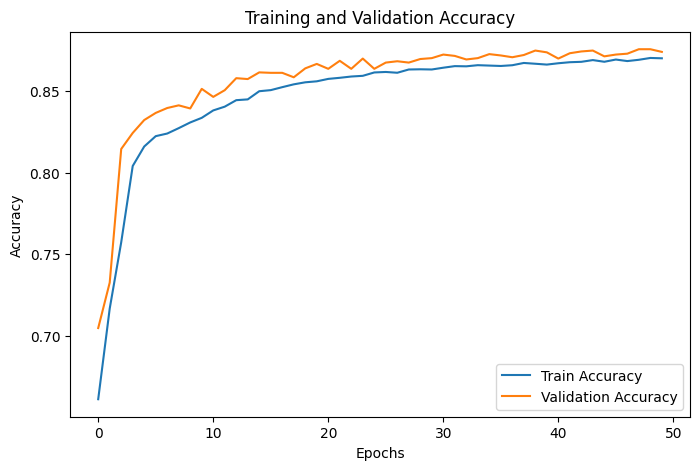

In [4]:
# MLP + LR Hybrid Model with Train/Test Accuracy, Loss, and Precision/Recall/F1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dessertation/phishing_numeric_dataset.csv')  # replace with your CSV path

# 2. Features and label
features = ['sender', 'receiver', 'subject', 'body', 'urls', 'timestamp']  # numeric
X = df[features].values
y = df['label'].values  # 0=legit, 1=phishing

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 6. Get LR probabilities as new feature
train_lr_prob = lr_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
test_lr_prob = lr_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

# 7. Append LR probability to original features
X_train_hybrid = np.hstack([X_train, train_lr_prob])
X_test_hybrid = np.hstack([X_test, test_lr_prob])

# 8. Build MLP classifier
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_shape=(X_train_hybrid.shape[1],)))
mlp.add(Dropout(0.2))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

mlp.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 9. Train MLP and store history
history = mlp.fit(
    X_train_hybrid, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

# 10. Evaluate on training and test set
train_loss, train_acc = mlp.evaluate(X_train_hybrid, y_train, verbose=0)
test_loss, test_acc = mlp.evaluate(X_test_hybrid, y_test, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

# 11. Predictions on test set
y_pred_prob = mlp.predict(X_test_hybrid).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# 12. Precision, Recall, F1
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report & confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# 13. Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 14. Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 15. Plot training & validation accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6319 - loss: 0.6506 - val_accuracy: 0.7073 - val_loss: 0.5967
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7013 - loss: 0.5882 - val_accuracy: 0.7297 - val_loss: 0.5572
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7348 - loss: 0.5487 - val_accuracy: 0.7474 - val_loss: 0.5226
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7498 - loss: 0.5244 - val_accuracy: 0.7752 - val_loss: 0.4790
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7735 - loss: 0.4919 - val_accuracy: 0.8104 - val_loss: 0.4310
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8036 - loss: 0.4481 - val_accuracy: 0.8170 - val_loss: 0.4078
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8117 - loss: 0.4284 - val_accuracy: 0.8388 - val_loss: 0.3843
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8187 - loss: 0.4190 - val_accuracy: 0.8399 - val_

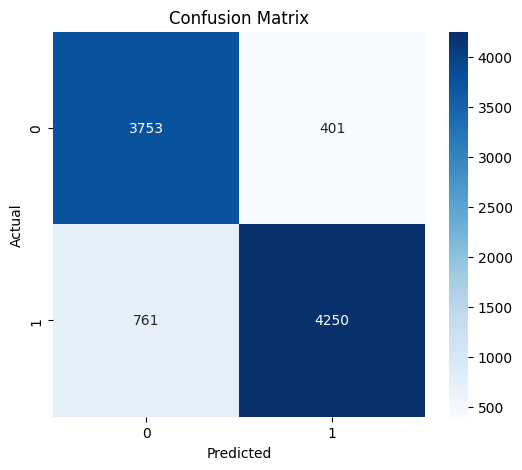

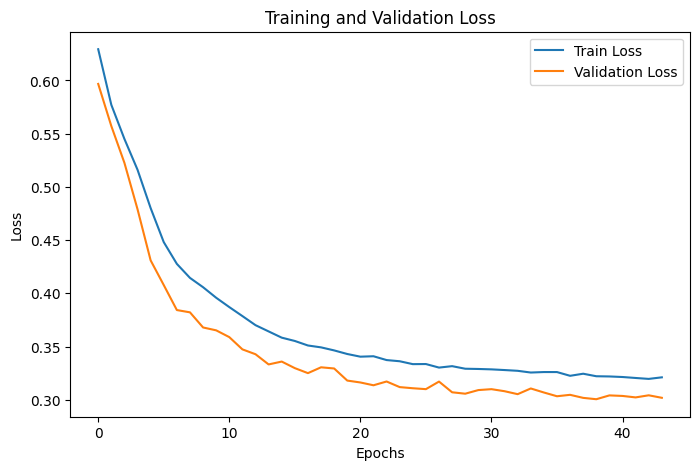

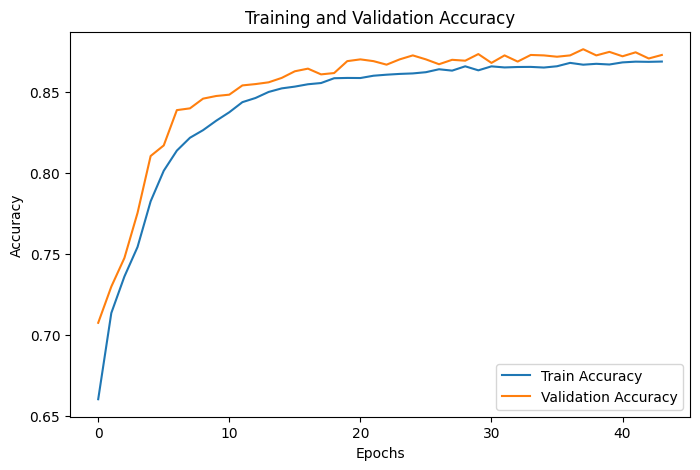

In [6]:
#MLP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, log_loss, precision_score,
                             recall_score, f1_score, classification_report,
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dessertation/phishing_numeric_dataset.csv')  # replace with your CSV path

# 2. Prepare features and label
features = ['sender', 'receiver', 'subject', 'body', 'urls', 'timestamp']  # numeric
X = df[features].values
y = df['label'].values  # 0=legit, 1=phishing

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Build MLP classifier
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
mlp.add(Dropout(0.2))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))  # binary classification

mlp.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 6. Train MLP and store history
history = mlp.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

# 7. Evaluate on training and test set
train_loss, train_acc = mlp.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = mlp.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

# 8. Predictions on test set
y_pred_prob = mlp.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# 9. Precision, Recall, F1
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report & confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# 10. Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 11. Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 12. Plot training & validation accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Train Accuracy: 0.5983
Test Accuracy: 0.6002
Train Log Loss: 0.6586
Test Log Loss: 0.6583
Precision: 0.6074
Recall: 0.7601
F1 Score: 0.6752

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.41      0.48      4154
           1       0.61      0.76      0.68      5011

    accuracy                           0.60      9165
   macro avg       0.60      0.58      0.58      9165
weighted avg       0.60      0.60      0.59      9165


Confusion Matrix:
 [[1692 2462]
 [1202 3809]]


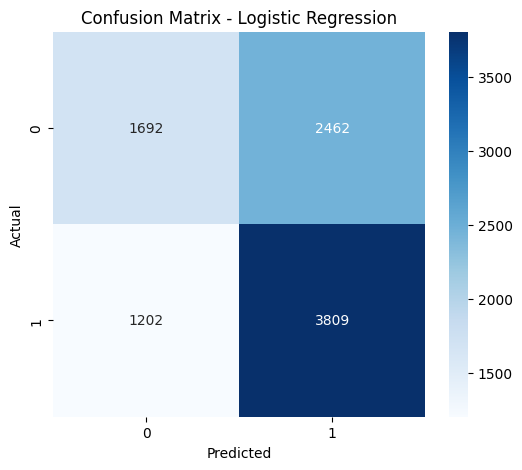

In [7]:
#LR
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, precision_score,
                             recall_score, f1_score, classification_report,
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dessertation/phishing_numeric_dataset.csv')  # replace with your CSV path

# 2. Prepare features and label
features = ['sender', 'receiver', 'subject', 'body', 'urls', 'timestamp']  # numeric
X = df[features].values
y = df['label'].values  # 0=legit, 1=phishing

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 6. Predictions
y_train_prob = lr_model.predict_proba(X_train)[:, 1]
y_test_prob = lr_model.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_prob > 0.5).astype(int)
y_test_pred = (y_test_prob > 0.5).astype(int)

# 7. Evaluation metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

train_ll = log_loss(y_train, y_train_prob)
test_ll = log_loss(y_test, y_test_prob)

prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train Log Loss: {train_ll:.4f}")
print(f"Test Log Loss: {test_ll:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:\n", cm)

# 8. Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()



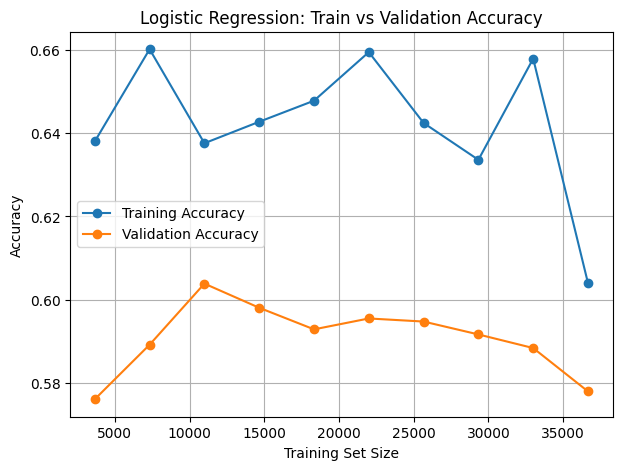

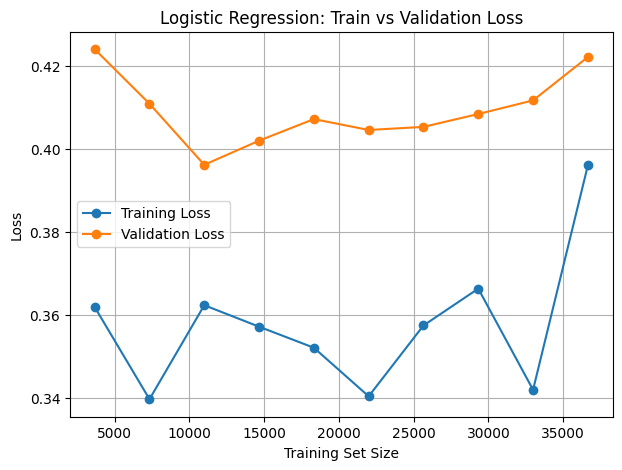

In [8]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Compute learning curves
train_sizes, train_scores, val_scores = learning_curve(
    lr_model,
    X_scaled,
    y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Mean scores
train_acc_mean = np.mean(train_scores, axis=1)
val_acc_mean = np.mean(val_scores, axis=1)

# Convert accuracy to loss
train_loss = 1 - train_acc_mean
val_loss = 1 - val_acc_mean

# ---- Accuracy Curve ----
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_acc_mean, marker='o', label='Training Accuracy')
plt.plot(train_sizes, val_acc_mean, marker='o', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Logistic Regression: Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ---- Loss Curve ----
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_loss, marker='o', label='Training Loss')
plt.plot(train_sizes, val_loss, marker='o', label='Validation Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Loss')
plt.title('Logistic Regression: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
